# TP : Algorithmes Génétiques pour la Détection de Bords avec PyGAD

Dans ce TP, nous implémenterons un algorithme génétique (GA) en Python pour concevoir automatiquement un **filtre convolutif de détection de bords**. L'objectif est d'approximer un filtre connu (ici, le filtre **Sobel**) en utilisant la bibliothèque d'algorithmes génétiques [PyGAD](https://pygad.readthedocs.io).

### Objectifs du TP :

- Concevoir un chromosome représentant un filtre convolutif.
- Définir une fonction d'évaluation mesurant la qualité d'un filtre par rapport au filtre de référence (Sobel).
- Configurer et exécuter l'algorithme génétique pour évoluer progressivement vers un filtre optimal.

> **Rappel :** Un **algorithme génétique** repose sur une analogie avec l'évolution biologique. Une population d'individus (solutions) est évaluée par une fonction dite de **fitness**. À chaque génération, on sélectionne les meilleurs individus pour former de nouveaux individus par **croisement** et **mutation**, permettant ainsi une exploration efficace de l'espace de solutions.


## Technologies et Bibliothèques utilisées

- **PyGAD** :  
  Bibliothèque Python facilitant l'implémentation d'algorithmes génétiques avec une interface simple et intuitive. PyGAD permet une personnalisation complète des opérateurs génétiques (sélection, croisement, mutation).

- **OpenCV (cv2)** :  
  Bibliothèque largement utilisée en vision par ordinateur pour la manipulation et le traitement d'images. Elle est notamment utilisée ici pour les convolutions et le filtrage.

- **Matplotlib** :  
  Bibliothèque pour la visualisation des résultats intermédiaires et finaux directement dans le notebook Jupyter.

Ces outils sont combinés pour démontrer la puissance des algorithmes évolutionnaires dans l'optimisation automatique des filtres de traitement d'image.


In [1]:
%pip install pygad opencv-python-headless matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


### Imports et Fonctions Utilitaires

Nous allons commencer par importer les bibliothèques nécessaires et définir les fonctions utilitaires.

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pygad import pygad

# Mode batch pour exécution non-interactive (Papermill/MCP)
import os
BATCH_MODE = os.getenv("BATCH_MODE", "false").lower() in ("true", "1", "yes")
if BATCH_MODE:
    plt.ioff()  # Désactive le mode interactif matplotlib

# Fonction pour sauvegarder une image
def save_image(image, filename):
    cv2.imwrite(filename, image)
    print(f"Image enregistrée : {filename}")

# Fonction pour convertir une image Bitmap en Matrice OpenCV
def bitmap_to_mat(bitmap):
    return cv2.cvtColor(np.array(bitmap), cv2.COLOR_BGR2RGB)

# Fonction pour afficher une image
def display_image(image, title="Image"):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()
    plt.close()  # Ferme la figure pour éviter blocage en mode batch

## Définition du Chromosome (EdgeChromosome)

Dans cette implémentation, chaque chromosome représente un filtre de convolution complet. Il est composé d'un ensemble de **gènes**, chacun étant une matrice 7x7 de coefficients. Le filtre final appliqué à l'image correspond à la somme de toutes ces matrices de gènes.

### Pourquoi utiliser cette approche ?

- **Évolution progressive** : Chaque gène apporte une contribution partielle au filtre complet, permettant à l'algorithme d'explorer graduellement des solutions.
- **Exploration efficace** : La mutation et le croisement agissent sur des sous-unités indépendantes, augmentant la diversité et facilitant l'optimisation.

Ci-dessous, nous définissons la classe Python correspondant à cette représentation.


In [3]:
class EdgeChromosome:
    def __init__(self, length):
        self.kernel_size = 7  # Définir kernel_size avant de l'utiliser dans generate_gene
        self.length = length
        self.genes = [self.generate_gene() for _ in range(length)]

    def generate_gene(self):
        return np.random.randint(-20, 20, (self.kernel_size, self.kernel_size), dtype=np.int64)

    def get_complete_matrix(self):
        complete_matrix = np.zeros((self.kernel_size, self.kernel_size), dtype=np.float32)
        for gene in self.genes:
            complete_matrix += gene.astype(np.float32)
        
        max_abs = np.max(np.abs(complete_matrix))
        if max_abs > 10:
            complete_matrix = 10.0 * complete_matrix / max_abs
        return complete_matrix
    

## Vérification du Chromosome créé

Testons maintenant la création d'un chromosome afin de vérifier que les gènes et la matrice résultante sont générés correctement.

**Attendu :** Une série de matrices 7x7 suivie d'une matrice résultante (somme normalisée).


In [4]:
test_chromosome = EdgeChromosome(5)
print("Gènes générés :")
for gene in test_chromosome.genes:
    print(gene)
    print()

test_matrix = test_chromosome.get_complete_matrix()
print("Matrice complète générée :")
print(test_matrix)

Gènes générés :
[[-14 -13  -9  10  14   0  -3]
 [-12  -2   5  -5  -9   7  10]
 [-13  -3   0 -12   6  -5  14]
 [ -8 -18 -12   8  19  10  15]
 [ 13  15 -20   6   2 -13   6]
 [-19  10  13  -8  18   6   1]
 [-16  -2   9   1   1 -19  -9]]

[[ 12   6 -11  16 -12  -1  10]
 [-20  10 -11  -3  -2  -2  -8]
 [ -9 -12 -17  12 -13   1  15]
 [ -9  16 -17 -19  -3  -4 -20]
 [-17   4  -8  19  -5  17   9]
 [ -4   6  13  14  14  -8   2]
 [ -3  12   6  14 -12 -10   8]]

[[ -7  10  -2  -2  -1  17 -17]
 [  9   0  16 -11   5  -9  10]
 [-10   6  -8   1   9  10   7]
 [ 19 -17  -9  -5  16  12 -17]
 [-13  17  -4 -16 -12  -5 -14]
 [  9   0   7   2   5   5  -7]
 [-19 -10  13  -7   9  -3 -18]]

[[-18  -4   0  14 -17  -9 -15]
 [ 16 -19  13 -19  17  10 -11]
 [-13 -18  19  12  -3 -15  -6]
 [  2   5 -20 -18  -6  -3 -12]
 [  2   2 -10  15   8  -9   8]
 [ 18  16   7  -5 -15  -7   9]
 [-19  -7   6  19   9 -13   8]]

[[-12  16   4  16   2  -5  -1]
 [ 16  13 -14 -20  -8 -10  -1]
 [-16  16  -6  18   7  -3  -8]
 [ 11   4   8  

## Fonction d'Évaluation (Fitness)

La **fonction d'évaluation** mesure la performance d'un filtre (chromosome) en comparant l'image obtenue par convolution avec l'image originale filtrée par le filtre Sobel (référence).  

### Étapes de l'évaluation :

1. **Filtrage convolutif** :  
   Le filtre généré par le chromosome est appliqué à l'image originale.

2. **Comparaison avec le filtre Sobel** :  
   L'image obtenue est comparée avec l'image de référence obtenue par le filtre Sobel, en utilisant une mesure de similarité (corrélation normalisée).

3. **Pénalisation des filtres uniformes** :  
   Pour éviter les solutions uniformes (avec des coefficients très faibles), une pénalité basée sur la somme absolue des coefficients du filtre est appliquée.

Cette approche permet de guider l'évolution vers des filtres capables de détecter efficacement les contours dans l'image.


In [5]:
import cv2
import numpy as np
import math

class EdgeFitness:
    def __init__(self, original_image):
        """
        Calcule l'image de référence via la magnitude du Sobel en X et Y, 
        normalisée dans la plage [0, 255].
        """
        # Conversion en niveaux de gris (8 bits)
        gray = cv2.cvtColor(np.array(original_image), cv2.COLOR_BGR2GRAY)

        # Sobel en X et Y
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)

        # Magnitude = sqrt(SobelX^2 + SobelY^2)
        magnitude = np.sqrt(sobelx**2 + sobely**2)

        # Normalisation manuelle dans [0, 255]
        if magnitude.max() > 0:
            magnitude = (magnitude / magnitude.max()) * 255.0
        magnitude = magnitude.astype(np.uint8)

        self.reference_image = magnitude
        self.original_gray = gray  # on conserve l'image 8 bits en nuances de gris

    def display_images(self):
        """
        Affiche l'image d'origine (gris) et l'image Sobel de référence.
        """
        # Image originale
        plt.figure(figsize=(12,5))
        plt.subplot(1,2,1)
        plt.imshow(self.original_gray, cmap='gray')
        plt.title("Original Gray")
        plt.axis('off')

        # Image Sobel
        plt.subplot(1,2,2)
        plt.imshow(self.reference_image, cmap='gray')
        plt.title("Sobel Reference")
        plt.axis('off')
        plt.show()
        plt.close()  # Ferme la figure pour éviter blocage en mode batch

    def apply_filter(self, chromosome, display=False):
        """
        Construit la matrice complète du chromosome et l'applique sur l'image originale via cv2.filter2D.
        Retourne le résultat normalisé en [0,255].
        """
        # Reconstruction du noyau en float32
        filter_matrix = chromosome.get_complete_matrix()
        if display:
            print("Noyau généré :\n", filter_matrix)

        # Appliquer la convolution avec un borderType par défaut
        filtered_float = cv2.filter2D(self.original_gray.astype(np.float32), ddepth=-1, kernel=filter_matrix, borderType=cv2.BORDER_DEFAULT)

        # Conversion en uint8 sans normalisation excessive
        filtered_uint8 = cv2.convertScaleAbs(filtered_float)
        return filtered_uint8


    def evaluate(self, solution, solution_idx):
        """
        Transforme le 'solution' en chromosome, applique le filtre, 
        puis compare avec l'image Sobel de référence via la corrélation normalisée.
        Applique la pénalisation sur la somme des coefficients.
        """
        # Reconstruire le chromosome depuis le vecteur 'solution'
        from math import log10

        # On suppose 20 gènes de 7x7 = 49 coeff par gène
        gene_count = 20
        gene_size = 49
        chromosome = EdgeChromosome(gene_count)
        for i in range(gene_count):
            start = i*gene_size
            end   = start + gene_size
            arr   = np.array(solution[start:end]).reshape(7,7).astype(np.int64)
            chromosome.genes[i] = arr

        # Filtrage
        filtered_img = self.apply_filter(chromosome, display=False)

        # Vérifier la taille/dtype vs reference
        if filtered_img.shape != self.reference_image.shape:
            filtered_img = cv2.resize(filtered_img, 
                                      (self.reference_image.shape[1], 
                                       self.reference_image.shape[0]))

        # Corrélation normalisée
        result = cv2.matchTemplate(filtered_img, self.reference_image, cv2.TM_CCORR_NORMED)
        _, maxVal, _, _ = cv2.minMaxLoc(result)

        # Calcul de la pénalisation identique à GeneticSharp 
        # (log10(|sumCoeffs| + 1))
        full_matrix = chromosome.get_complete_matrix()
        filter_sum = np.sum(full_matrix)
        filter_penalty = 1.0
        if abs(filter_sum) >= 1e-3:
            filter_penalty = log10(abs(filter_sum) + 1.0)

        # Score final
        # multiplier éventuellement par 1000 pour avoir un range plus large
        score = (maxVal * 1000.0) / filter_penalty

        return score

    def display_chromosome_result(self, chromosome, filename_prefix, generation):
        """
        Affiche ou sauvegarde l'image filtrée (optionnel).
        """
        filtered_img = self.apply_filter(chromosome, display=True)
        filename = f"{filename_prefix}_generation_{generation}.png"

        cv2.imwrite(filename, filtered_img)
        print(f"Image enregistrée : {filename}")

        plt.figure()
        plt.imshow(filtered_img, cmap='gray')
        plt.title(f"Generation {generation}")
        plt.axis('off')
        plt.show()
        plt.close()  # Ferme la figure pour éviter blocage en mode batch

### Test de la Fonction Fitness

Test de la fonction fitness.

In [6]:
from PIL import Image
# Test de la fonction fitness
image_path = r"MRI_Prostate_Cancer.jpg"
original_image = Image.open(image_path)
fitness = EdgeFitness(original_image)

# Test d'un chromosome
chromosome = EdgeChromosome(20)
print(f"Score de fitness : {fitness.evaluate(np.concatenate([gene.flatten() for gene in chromosome.genes]), 0)}")

Score de fitness : 315.97232998032706


## Configuration de l'Algorithme Génétique avec PyGAD

Nous configurons l'algorithme génétique à l'aide des paramètres suivants :

- **Taille de la population :** Nombre total d'individus testés à chaque génération.
- **Sélection :** Stratégie pour choisir les parents les mieux adaptés (`"sss"` : steady-state selection).
- **Croisement :** Combinaison des gènes des parents pour créer des enfants (`"uniform"` : croisement uniforme).
- **Mutation :** Modifications aléatoires pour introduire de nouvelles variations (`"random"` avec 10 % de gènes mutés à chaque génération).
- **Critère d'arrêt :** Nombre fixé de générations (ici, 100 générations).

Ces choix influencent directement la qualité et la rapidité de la convergence vers une solution optimale.


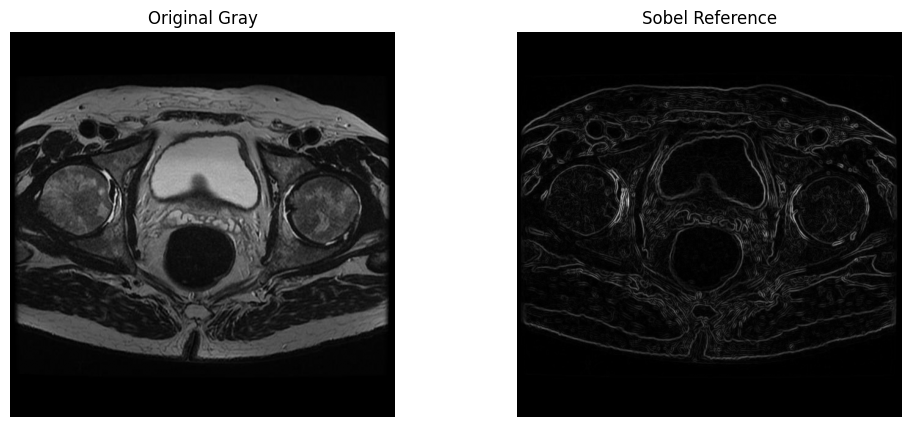

In [7]:
# -------------------------------------------------------------------
# A) Charger l'image avec PIL ou cv2, puis créer l'objet Fitness
# -------------------------------------------------------------------

image_path = r"MRI_Prostate_Cancer.jpg"  # Remplacez par le chemin de votre image

original_image = Image.open(image_path)

# Créer notre objet fitness
fitness_object = EdgeFitness(original_image)
fitness_object.display_images()  # Pour vérifier l'image de référence Sobel

# -------------------------------------------------------------------
# B) Définir la fonction de fitness pour PyGAD
# -------------------------------------------------------------------
def fitness_func(ga_instance, solution, solution_idx):
    return fitness_object.evaluate(solution, solution_idx)

# -------------------------------------------------------------------
# C) Callback pour la visualisation à chaque génération
# -------------------------------------------------------------------
def on_generation(ga_instance):
    best_solution, best_solution_fitness, best_match_idx = ga_instance.best_solution()
    print(f"Génération {ga_instance.generations_completed} - Meilleur score : {best_solution_fitness}")

    # Affiche l'image tous les 10 tours
    if ga_instance.generations_completed % 10 == 0:
        # Reconstruire le chromosome
        gene_count = 20
        gene_size  = 49
        best_chromosome = EdgeChromosome(gene_count)
        for i in range(gene_count):
            start = i*gene_size
            end   = start + gene_size
            arr   = np.array(best_solution[start:end]).reshape(7,7).astype(np.int64)
            best_chromosome.genes[i] = arr

        fitness_object.display_chromosome_result(best_chromosome, "best", ga_instance.generations_completed)

# -------------------------------------------------------------------
# D) Configurer et lancer le GA
#    - 20 gènes, chaque gène = 7x7 = 49 coefficients
#    - On veut donc un chromosome de 20*49 = 980 coefficients
# -------------------------------------------------------------------
import pygad

chromosome_length = 20 * 49  # 980
population_size  = (100, chromosome_length)  # Ex.: 100 individus

ga_instance = pygad.GA(
    num_generations = 100,
    num_parents_mating = 10,
    fitness_func = fitness_func,
    sol_per_pop = population_size[0],
    num_genes = population_size[1],
    init_range_low = -20,
    init_range_high = 20,
    parent_selection_type = "sss",
    keep_parents = -1,
    crossover_type = "uniform",
    mutation_type = "random",
    mutation_percent_genes = 10,
    on_generation = on_generation
)


## Exécution de l'Algorithme et Visualisation des Résultats

Lors de l'exécution de l'algorithme génétique, nous visualisons régulièrement :

- **L'évolution du meilleur score** à chaque génération, indiquant comment l'algorithme progresse.
- **Les images filtrées intermédiaires** obtenues toutes les 10 générations pour suivre visuellement l'amélioration du filtre.

Cela permet une compréhension intuitive du comportement de l'algorithme et de sa capacité à améliorer progressivement la solution.


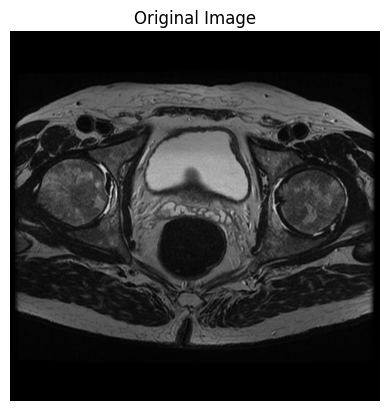

Génération 1 - Meilleur score : 12890.356663468527
Génération 2 - Meilleur score : 12890.356663468527
Génération 3 - Meilleur score : 18564.844288613007
Génération 4 - Meilleur score : 18564.844288613007
Génération 5 - Meilleur score : 18564.844288613007
Génération 6 - Meilleur score : 18564.844288613007
Génération 7 - Meilleur score : 18564.844288613007
Génération 8 - Meilleur score : 18564.844288613007
Génération 9 - Meilleur score : 18564.844288613007
Génération 10 - Meilleur score : 18564.844288613007
Noyau généré :
 [[ 1.9230769   2.1153846  -1.1538461  -3.75       -4.7115383   3.9423077
  -3.4615386 ]
 [ 1.0576923   4.6153846  -1.3461539  -1.25        3.75       -4.9038463
   2.7884614 ]
 [ 0.7692308   2.3076923   3.75        3.2692308  -0.5769231   7.5
   4.1346154 ]
 [-5.1923075  -6.1538463   0.28846154  0.5769231   1.4423077  -1.8269231
  -7.1153846 ]
 [ 3.0769231   1.8269231  -4.9038463   1.3461539   7.8846154   2.2115386
  -3.8461537 ]
 [-1.6346154  -2.6923077  -2.4038463  -

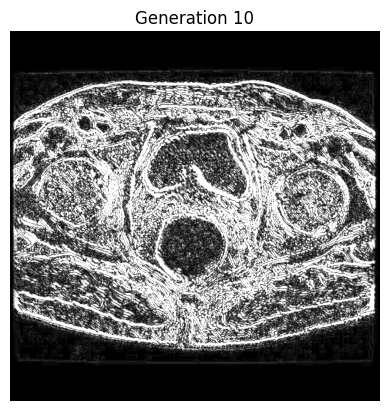

Génération 11 - Meilleur score : 18564.844288613007
Génération 12 - Meilleur score : 18958.00311403368
Génération 13 - Meilleur score : 18958.00311403368
Génération 14 - Meilleur score : 18958.00311403368
Génération 15 - Meilleur score : 18958.00311403368
Génération 16 - Meilleur score : 18958.00311403368
Génération 17 - Meilleur score : 18958.00311403368
Génération 18 - Meilleur score : 18958.00311403368
Génération 19 - Meilleur score : 18958.00311403368
Génération 20 - Meilleur score : 21601.957807076396
Noyau généré :
 [[ 0.          2.631579   -2.0175438  -4.5614033  -1.9298246   4.6491227
  -3.245614  ]
 [ 1.1403508   4.0350876  -3.0701754   0.5263158   4.2105265  -2.5438597
   2.9824562 ]
 [ 0.         -1.6666666   5.0877194   1.8421053  -1.4035088  10.
  -2.631579  ]
 [-4.8245616  -2.7192984   1.754386   -3.3333333  -0.61403507  3.4210527
  -4.5614033 ]
 [ 4.5614033   0.4385965  -3.7719297   4.736842    2.631579   -2.0175438
  -0.5263158 ]
 [-0.4385965  -2.7192984  -2.0175438  -

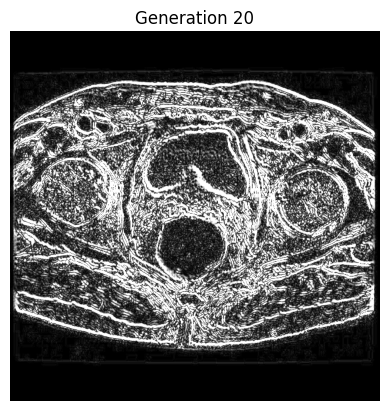

Génération 21 - Meilleur score : 21601.957807076396
Génération 22 - Meilleur score : 21793.282698163508
Génération 23 - Meilleur score : 21793.282698163508
Génération 24 - Meilleur score : 21793.282698163508
Génération 25 - Meilleur score : 21793.282698163508
Génération 26 - Meilleur score : 21793.282698163508
Génération 27 - Meilleur score : 21793.282698163508


In [ ]:
# Initialiser le placeholder avec l'image originale
display_image(bitmap_to_mat(original_image), "Original Image")

ga_instance.run()

best_solution, best_solution_fitness, best_match_idx = ga_instance.best_solution()
best_chromosome = EdgeChromosome(20)
best_chromosome.genes = [np.array(best_solution[i:i+49]).reshape(7, 7).astype(np.int64) for i in range(0, len(best_solution), 49)]
fitness.display_chromosome_result(best_chromosome, "best", ga_instance.generations_completed)
print(f"Meilleure solution trouvée avec un score de {best_solution_fitness}.")

## Conclusion et Perspectives

Dans ce TP, nous avons montré comment les algorithmes génétiques peuvent automatiser l'optimisation de filtres convolutifs pour la détection de bords. Cette approche permet une optimisation efficace de problèmes complexes en traitement d'image, en tirant parti de l'évolution naturelle pour explorer l'espace des solutions.

### Améliorations et perspectives possibles :

- Expérimenter avec différentes configurations des opérateurs génétiques (sélection, croisement, mutation) pour améliorer encore les résultats.
- Appliquer cette méthode à d'autres types de filtres ou à des images issues de différents contextes (médicales, satellites, etc.).
- Comparer les performances obtenues avec PyGAD en Python à celles obtenues avec GeneticSharp en C# pour évaluer les avantages de chaque technologie.

Cette méthode pédagogique met en évidence le potentiel et la flexibilité des algorithmes évolutionnaires en intelligence artificielle appliquée.
